In [1]:
import pandas as pd

#load the dataset
df = pd.read_csv('Casestudy2-Data-Py/bbc.csv',encoding='cp1252')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
TEXT            200 non-null object
URI             200 non-null object
NAME            200 non-null object
FILTERED        200 non-null object
LANGUAGE        200 non-null object
CREATED         200 non-null int64
ACCESSED        200 non-null int64
MODIFIED        200 non-null int64
TRUNCATED       200 non-null int64
OMITTED         200 non-null int64
EXTENSION       200 non-null object
SIZE            200 non-null int64
FILTEREDSIZE    200 non-null int64
dtypes: int64(7), object(6)
memory usage: 20.4+ KB


In [2]:
# average length of text column
print(df['TEXT'].apply(lambda x: len(x)).mean())

1928.06


In [3]:
# print out the first 200 characters of the first row of text column
print(df.get_value(index=0, col='TEXT')[:500])


Claxton hunting first major medal  British hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.  The 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. "I am quite confident," said Claxton. "But I take each race as it comes. "As long as I keep up my training but not do too much I think there is a chance of a medal." Claxton has won


/Users/Ding/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [4]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [5]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

# load the provided stopwords
df_stop = pd.read_csv('Casestudy2-Data-Py/bbc.csv')

# join provided stopwords with the default NLTK English stopwords
#stopwords = set(df_stop['TEXT']).union(set(sw.words('english')))
stopwords = sw.words('english')
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [6]:
def cab_tokenizer(document):
    #initialize token list
    tokens = []
    
    #split the document into sentences
    for sent in sent_tokenize(document):
        #split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            #preprocess and remove unnecssary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            # if stopword, ignore token and continue
            if token in stopwords:
                continue
                
            #if punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue
                
            # lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
            
    return tokens

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['TEXT'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

36377


In [8]:
#initial
from sklearn.cluster import KMeans

rs=42

# K means clustering using the term vector
kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)

In [9]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: indoor, world, record, olympic, bekele, 
Top terms for cluster 1: cricket, club, ï, ¿, ï ¿, 
Top terms for cluster 2: ball, wicket, run, strauss, australia, 
Top terms for cluster 3: england, ireland, wale, nation, rugby, 
Top terms for cluster 4: 6, open, hewitt, win, 7, 
Top terms for cluster 5: say, cup, roddick, player, play, 
Top terms for cluster 6: athletics, athens, drug, ban, athlete, 


In [10]:
#Zipf's Law
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,6)

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['TEXT'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(df['TEXT'])

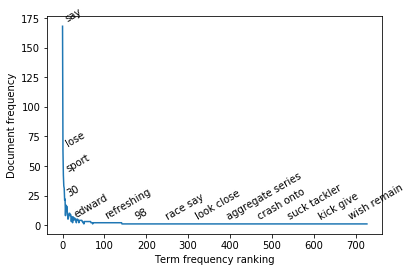

In [11]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

In [12]:
terms

[{'df': 168, 'idx': 27408, 'term': 'say', 'tf': 447},
 {'df': 134, 'idx': 35981, 'term': 'year', 'tf': 308},
 {'df': 106, 'idx': 13265, 'term': 'game', 'tf': 249},
 {'df': 102, 'idx': 35283, 'term': 'win', 'tf': 246},
 {'df': 104, 'idx': 23790, 'term': 'play', 'tf': 240},
 {'df': 104, 'idx': 22408, 'term': 'one', 'tf': 204},
 {'df': 112, 'idx': 14001, 'term': 'go', 'tf': 203},
 {'df': 112, 'idx': 31402, 'term': 'take', 'tf': 202},
 {'df': 52, 'idx': 10540, 'term': 'england', 'tf': 199},
 {'df': 103, 'idx': 33428, 'term': 'two', 'tf': 197},
 {'df': 115, 'idx': 32505, 'term': 'time', 'tf': 189},
 {'df': 89, 'idx': 12262, 'term': 'first', 'tf': 185},
 {'df': 92, 'idx': 35707, 'term': 'world', 'tf': 180},
 {'df': 87, 'idx': 13624, 'term': 'get', 'tf': 175},
 {'df': 82, 'idx': 23957, 'term': 'player', 'tf': 164},
 {'df': 108, 'idx': 19526, 'term': 'make', 'tf': 163},
 {'df': 93, 'idx': 35785, 'term': 'would', 'tf': 156},
 {'df': 85, 'idx': 3638, 'term': 'back', 'tf': 149},
 {'df': 85, 'idx'

In [13]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(df['TEXT'])


# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

6917


In [14]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)

CPU times: user 4.51 s, sys: 152 ms, total: 4.66 s
Wall time: 1.18 s


In [15]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: open, 6, australian, australian open, hewitt, 
Top terms for cluster 1: england, rugby, wale, ireland, nation, 
Top terms for cluster 2: club, chelsea, game, play, player, 
Top terms for cluster 3: drug, ban, greek, iaaf, test, 
Top terms for cluster 4: roddick, spain, moya, davis cup, davis, 
Top terms for cluster 5: pakistan, test, cricket, series, wicket, 
Top terms for cluster 6: race, world, year, indoor, olympic, 


In [16]:
#SVD 

In [17]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

In [18]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 england, year, win, play, game, 
Top terms in component #1 6, open, 7, roddick, moya, 
Top terms in component #2 athens, athletics, race, world, chepkemei, 
Top terms in component #3 test, ball, wicket, run, pakistan, 
Top terms in component #4 ireland, wale, england, nation, six nation, 
Top terms in component #5 greek, drug, kenteris, test, iaaf, 
Top terms in component #6 arsenal, greek, kenteris, chelsea, drug, 
Top terms in component #7 roddick, moya, cricket, davis cup, davis, 
Top terms in component #8 chepkemei, marathon, cross country, radcliffe, cross, 
Top terms in component #9 pakistan, moya, australia, roddick, victory, 


In [19]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=7, random_state=rs).fit(X_trans)

CPU times: user 250 ms, sys: 26.5 ms, total: 276 ms
Wall time: 82.5 ms


In [20]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: race, world, marathon, year, paula, 
Top terms for cluster 1: club, want, liverpool, game, chelsea, 
Top terms for cluster 2: test, pakistan, greek, athletics, iaaf, 
Top terms for cluster 3: england, rugby, wale, cricket, nation, 
Top terms for cluster 4: 6, 7, roddick, moya, 7 6, 
Top terms for cluster 5: england, strauss, vaughan, trescothick, south, 
Top terms for cluster 6: open, australian, australian open, year, federer, 


In [21]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

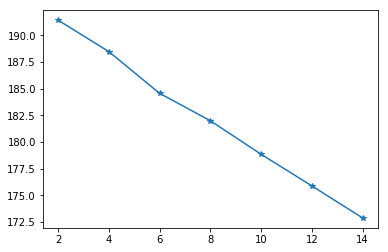

In [22]:
# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.show()

In [27]:
from sklearn.metrics import silhouette_score

print(clusters[2])
print("Silhouette score for k=6", silhouette_score(X, clusters[2].predict(X)))

print(clusters[3])
print("Silhouette score for k=7", silhouette_score(X, clusters[3].predict(X)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.011227335238124999
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=7 0.011307695113073148
